## Задача по анализу поиска в Яндекс Картинках

In [72]:
pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=1ad57250170a648aef4f3e4b8d6bccbc356db9808ab49ae1c79eac6fc1255f77
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [102]:
import pandas as pd

# Считываем данные из файла
df = pd.read_csv(
    "data.tsv",
    sep="\t",
    header=None,
    names=["query", "timestamp", "platform"]
)

df.head()


,query,timestamp,platform
0,малевич картины,1631806465,desktop
1,психология,1631781583,touch
2,с днём рождения лена,1631771563,touch
3,зверополис фильмы,1631787599,touch
4,алабай собака фото,1631786645,touch


### 1. Укажите даты диапазона, предоставленного вам для анализа

In [103]:
# Преобразуем информацию о времени запроса из unix формата в формат Дата-время
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df["date"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour

In [104]:
df

,query,timestamp,platform,datetime,date,hour
0,малевич картины,1631806465,desktop,2021-09-16 15:34:25,2021-09-16,15
1,психология,1631781583,touch,2021-09-16 08:39:43,2021-09-16,8
2,с днём рождения лена,1631771563,touch,2021-09-16 05:52:43,2021-09-16,5
3,зверополис фильмы,1631787599,touch,2021-09-16 10:19:59,2021-09-16,10
4,алабай собака фото,1631786645,touch,2021-09-16 10:04:05,2021-09-16,10
...,...,...,...,...,...,...
1114360,бабочка,1631475653,touch,2021-09-12 19:40:53,2021-09-12,19
1114361,все республики россии,1631462934,touch,2021-09-12 16:08:54,2021-09-12,16
1114362,кухня в стиле лофт,1631432252,touch,2021-09-12 07:37:32,2021-09-12,7
1114363,топор,1631449347,desktop,2021-09-12 12:22:27,2021-09-12,12


In [105]:
# Извлекаем минимальное и максимальное значение в столбце "date"
date_min = df["date"].min()
date_max = df["date"].max()

print(
    f"Диапазон дат в данных: "
    f"{date_min.strftime('%d.%m.%Y')} – {date_max.strftime('%d.%m.%Y')}"
)

Диапазон дат в данных: 31.08.2021 – 21.09.2021


In [106]:
df.to_csv("search_analysis.csv", index=False)

### 2. Рассчитайте количество запросов с текстом "ютуб" в каждой платформе (desktop, touch)

In [81]:
# Ищем вхождение подстроки "ютуб" в строку запроса (столбец "query")
youtube_df = df[df["query_norm"].str.contains("ютуб", case=False, na=False)]

# Группируем полученные результаты по типу платформы, чтобы посчитать количество методом size()
youtube_df.groupby("platform").size()

,0
platform,
desktop,806
touch,732


In [107]:
youtube_df.to_csv("youtube_df.csv", index=False)

Select-запрос в SQL:

In [84]:
# SQL рабоатет с кириллицей и обрабатывает нижний регистр иначе, чем pandas,
# чтобы результаты совпадали, нужно заранее нормализовать данные
df["query_norm"] = (
    df["query"]
    .str.lower()         # Приводим к нижнему регистру
    .str.replace("ё", "е")  # Заменяем ё на е
    .str.strip()         # Убираем лишние пробелы в начале/конце
)


In [86]:
from pandasql import sqldf

sqldf("""
SELECT
    platform,
    COUNT(*) AS count
FROM df
WHERE query_norm LIKE '%ютуб%'
GROUP BY platform
""")


,platform,count
0,desktop,806
1,touch,732


### 3. Выведите топ10 самых частотных запросов в каждой платформе (desktop, touch).

In [111]:
# Подсчитываем количество запросов и сортируем по типу платформы
top_queries = (
    df.groupby(["platform", "query"])
      .size()
      .reset_index(name="count")
      .sort_values(["platform", "count"], ascending=[True, False])
)

# Ранжируем полученные значения, чтобы можно было сделать фильтр в DataLens
top_queries["rank"] = (
    top_queries.groupby("platform")["count"]
    .rank(method="first", ascending=False)
)

# Группируем данные по типу платформы и выводим топ-10 результатов
top_queries.groupby("platform").head(10)


,platform,query,count,rank
9108,desktop,календарь 2021,2804,1.0
20808,desktop,таблица менделеева,2631,2.0
9482,desktop,картинки,1647,3.0
3359,desktop,английский алфавит,1293,4.0
14159,desktop,обои на рабочий стол,1143,5.0
2357,desktop,Одноклассники (социальная сеть),1116,6.0
20800,desktop,таблица квадратов,877,7.0
3215,desktop,алфавит,874,8.0
20848,desktop,таблица умножения,867,9.0
9385,desktop,карта мира,795,10.0


In [112]:
top_queries.to_csv("top_queries.csv", index=False)

По результату можно судить о том, что запросы с версии **desktop** чаще имеют справочный характер (*таблица Менделеева, алфавит, календарь*), это может говорить об использовании этой версии для работы или учёбы, о более длительных сессиях и использовании изображений в качестве вспомогательных инструментов.


Мобильные устройства (**touch**) чаще используются для развлечений (*фильмы, игры*), повседневных сценариев (*новости, погода*) или социальных взаимодействий (*поздравления*). Это может говорит о менее длительных сессиях и использовании сервиса в свободное время.

Решение на SQL:

In [93]:
sql_top10_desktop = sqldf("""
SELECT query, COUNT(*) AS count
FROM df
WHERE platform = 'desktop'
GROUP BY query
ORDER BY count DESC
LIMIT 10
""")

In [94]:
sql_top10_touch = sqldf("""
SELECT query, COUNT(*) AS count
FROM df
WHERE platform = 'touch'
GROUP BY query
ORDER BY count DESC
LIMIT 10
""")

In [95]:
sql_top10_desktop

,query,count
0,календарь 2021,2804
1,таблица менделеева,2631
2,картинки,1647
3,английский алфавит,1293
4,обои на рабочий стол,1143
5,Одноклассники (социальная сеть),1116
6,таблица квадратов,877
7,алфавит,874
8,таблица умножения,867
9,карта мира,795


In [96]:
sql_top10_touch

,query,count
0,с днём рождения женщине,4903
1,с днём рождения,3967
2,с днём рождения мужчине,3623
3,с днем рождения,3005
4,погода,2840
5,игры,2833
6,фильмы,2746
7,новости,2708
8,музыка,2696
9,мода,2648


### 4. Отличие трафика запросов в течении дня.

In [41]:
# Подсчитываем количество запросов для каждого часа дня, группируя по типу платформы
hourly = (
    df.groupby(["platform", "hour"])
      .size()
      .reset_index(name="count")
)

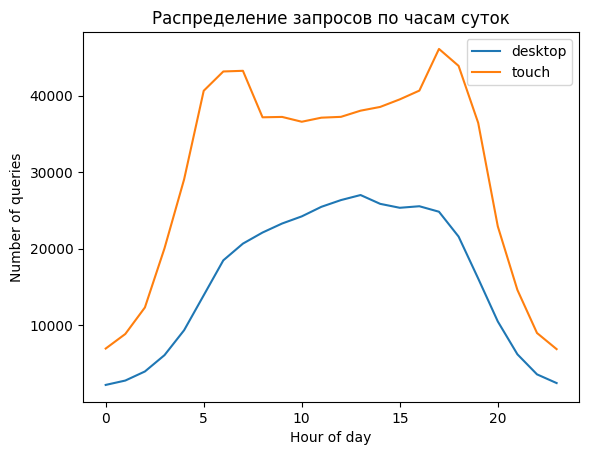

In [43]:
import matplotlib.pyplot as plt

# Проходим по всем уникальным платформам (desktop, touch)
for platform in hourly["platform"].unique():

    # Отбираем данные только для текущей платформы
    subset = hourly[hourly["platform"] == platform]

    # Строим линию: по оси X — часы суток, по оси Y — количество запросов
    plt.plot(
        subset["hour"],
        subset["count"],
        label=platform  # подпись линии в легенде
    )

plt.legend()

plt.xlabel("Hour of day")
plt.ylabel("Number of queries")

plt.title("Распределение запросов по часам суток")

plt.show()



In [109]:
hourly.to_csv("hourly_traffic.csv", index=False)

На мобильных устройствах активность выше утром и вечером, что говорит об использовании мобильных устройств (**touch**) в дороге и дома.
**Desktop**-трафик более равномерный и сконцентрирован в рабочие часы, что подтверждает использование сервиса в рабочих и учебных сценариях.

In [100]:
sql_hourly = sqldf("""
SELECT platform, hour, COUNT(*) AS count
FROM df
GROUP BY platform, hour
ORDER BY platform, hour
"""
)

In [101]:
sql_hourly

,platform,hour,count
0,desktop,0,2234
1,desktop,1,2805
2,desktop,2,3989
3,desktop,3,6122
4,desktop,4,9375
5,desktop,5,13932
6,desktop,6,18494
7,desktop,7,20674
8,desktop,8,22120
9,desktop,9,23299


### 5. Тематики запросов, контрастные для мобильных и компьютеров

In [65]:
# Создаём словарь тем
THEMES = {
    "поздравления": ["поздрав", "доброе утро", "c днем", "с днём"],
    "кино": ["фильм", "кадр", "сериал", "кино", "смотреть онлайн"],
    "музыка": ["музыка", "песня", "клип"],
    "игры": ["игры", "игра", "аркада"],
    "погода": ["погода", "дождь", "прогноз"],
    "животные": ["собака", "кошка", "мышь", "лошадь", "порода", "бабочка", "слон"],
    "образование": ["алфавит", "таблица", "карта", "календарь", "логия"],
    "искусство": ["картины", "театр", "постановка", "картинная", "выставка", "картина"],
    "техника": ["ноутбук", "айфон", "телефон", "смартфон"],
    "мода": ["мода", "одежда", "платье", "джинсы", "брюки", "футболка", "рубашка"],
}

def theme(query):
    # Переводим текст запроса к нижнему регистру
    q = query.lower()
    # Проходим по словарю
    for theme, keywords in THEMES.items():
        # Ищем в строке запроса ключевые слова из словаря
        if any(word in q for word in keywords):
            return theme
    return "прочее"

df["theme"] = df["query"].apply(theme)


In [67]:
# Убираем "прочее", чтобы эта тема не искажала результаты (недостаток подхода - сложно перебрать все возможные темы)
filtered_df = df[df["theme"] != "прочее"]

In [68]:
theme_share = (
    filtered_df.groupby(["platform", "theme"])
      .size()
      .reset_index(name="count")
)

# Считаем долю запросов с этой темой, группируя по типу платформы
theme_share["share"] = (
    theme_share
    .groupby("platform")["count"]
    .transform(lambda x: x / x.sum())
)

theme_share


,platform,theme,count,share
0,desktop,животные,1755,0.034844
1,desktop,игры,1606,0.031885
2,desktop,искусство,780,0.015486
3,desktop,кино,2627,0.052156
4,desktop,мода,1141,0.022653
5,desktop,музыка,1079,0.021422
6,desktop,образование,32526,0.645767
7,desktop,погода,1132,0.022475
8,desktop,поздравления,5766,0.114477
9,desktop,техника,1956,0.038834


In [69]:
# Создаём новую таблицу, чтобы облегчить построение графика
pivot = theme_share.pivot(
    index="theme",
    columns="platform",
    values="share"
).fillna(0)

pivot


platform,desktop,touch
theme,,
животные,0.034844,0.025072
игры,0.031885,0.038006
искусство,0.015486,0.005319
кино,0.052156,0.065223
мода,0.022653,0.038122
музыка,0.021422,0.035098
образование,0.645767,0.240384
погода,0.022475,0.039484
поздравления,0.114477,0.436858


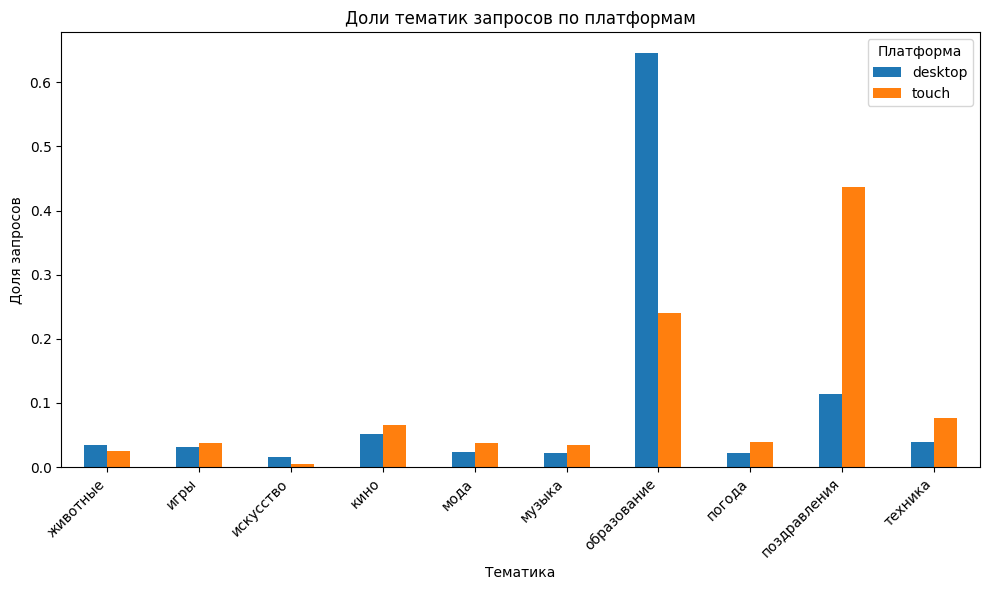

In [70]:
import matplotlib.pyplot as plt

# Размер графика
plt.figure(figsize=(10, 6))

# Столбцы для desktop и touch
pivot.plot(
    kind="bar",
    ax=plt.gca()
)

# Подписи
plt.title("Доли тематик запросов по платформам")
plt.xlabel("Тематика")
plt.ylabel("Доля запросов")

# Поворот подписей по оси X
plt.xticks(rotation=45, ha="right")

# Легенда
plt.legend(title="Платформа")

plt.tight_layout()
plt.show()


Анализ тематик запросов показал выраженные различия между платформами.
На мобильных устройствах (**touch**) значительно выше доля социальных и развлекательных тем, таких как поздравления и медиа-контент.
В то же время **desktop**-платформа характеризуется большей долей образовательных и справочных запросов.
Это подтверждает гипотезу о различии пользовательских сценариев на разных устройствах (**desktop** - образование и работа, **touch** - развлечения, повседневные задачи)

In [110]:
theme_share.to_csv("theme_share.csv", index=False)